In [1]:
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost

from scipy.stats import norm

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,  OrdinalEncoder #### ORDINAL
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# select and train model
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
REP_DATA = Path('data')
REP_DATA.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile('house-prices-advanced-regression-techniques.zip', 'r') as zip_f:
    zip_f.extractall(REP_DATA)

In [3]:
df = pd.read_csv(
    REP_DATA / 'train.csv'
)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
# purge column with more than x % of NaN values
df = df.loc[:, df.isnull().mean().sort_values(ascending=False) < .15]

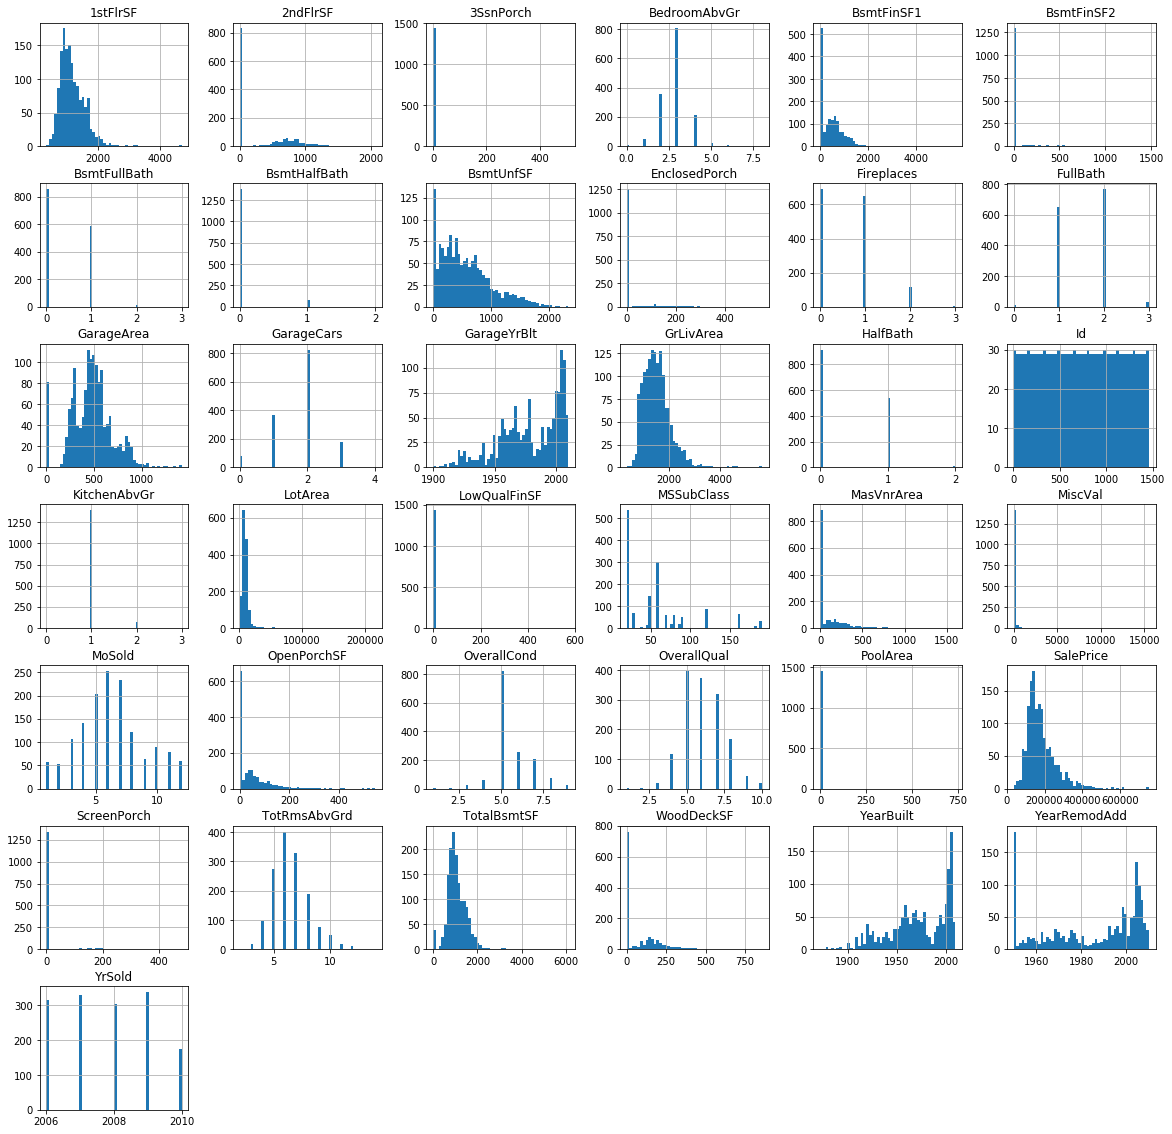

In [6]:
df.hist(bins=50, figsize=(20, 20))
plt.show()

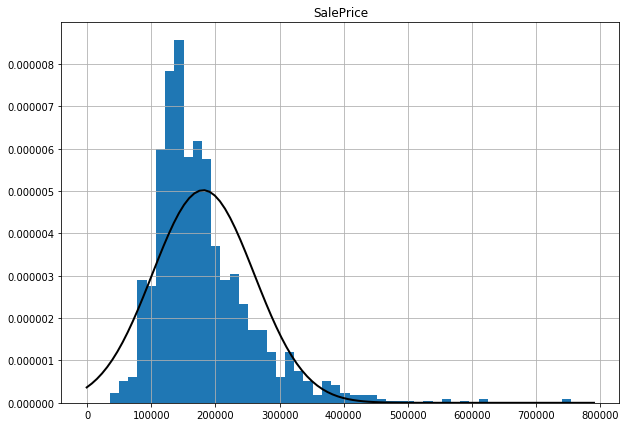

In [7]:
df[['SalePrice']].hist(bins=50, figsize=(10, 7), density=True)

# Fit a normal distribution to the data:
mu, std = norm.fit(df[['SalePrice']])
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.show()

In [8]:
# Skewness is the degree of distortion from the normal curve.
# A symmetrical distribution will have a skewness of "0". 
df['SalePrice'].skew()

1.8828757597682129

In [9]:
#df['SalePrice'] = np.log(df['SalePrice'])
df['SalePrice'] = np.log1p(df['SalePrice'])

In [10]:
df['SalePrice'].skew()

0.12134661989685333

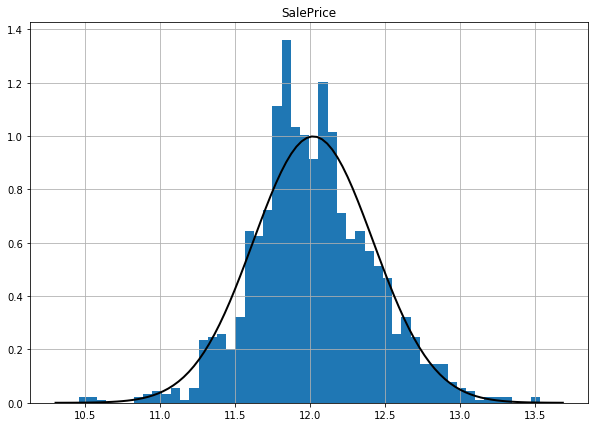

In [11]:
df[['SalePrice']].hist(bins=50, figsize=(10, 7), density=True)

# Fit a normal distribution to the data:
mu, std = norm.fit(df[['SalePrice']])
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.show()

In [12]:
df.nunique().sort_values(ascending=False)

Id            1460
LotArea       1073
GrLivArea      861
BsmtUnfSF      780
1stFlrSF       753
              ... 
HalfBath         3
PavedDrive       3
CentralAir       2
Utilities        2
Street           2
Length: 75, dtype: int64

In [13]:
df.select_dtypes('object').nunique().sort_values(ascending=False)

for c in df.select_dtypes('object'):
    df[c] = df[c].astype('category')

In [14]:
df.select_dtypes('number').nunique().sort_values(ascending=False)

Id               1460
LotArea          1073
GrLivArea         861
BsmtUnfSF         780
1stFlrSF          753
TotalBsmtSF       721
SalePrice         663
BsmtFinSF1        637
GarageArea        441
2ndFlrSF          417
MasVnrArea        327
WoodDeckSF        274
OpenPorchSF       202
BsmtFinSF2        144
EnclosedPorch     120
YearBuilt         112
GarageYrBlt        97
ScreenPorch        76
YearRemodAdd       61
LowQualFinSF       24
MiscVal            21
3SsnPorch          20
MSSubClass         15
MoSold             12
TotRmsAbvGrd       12
OverallQual        10
OverallCond         9
PoolArea            8
BedroomAbvGr        8
YrSold              5
GarageCars          5
BsmtFullBath        4
KitchenAbvGr        4
Fireplaces          4
FullBath            4
HalfBath            3
BsmtHalfBath        3
dtype: int64

In [15]:
train_set, test_set = train_test_split(
    df,
    test_size=.02,
    random_state=24
)

X_train = train_set.copy()

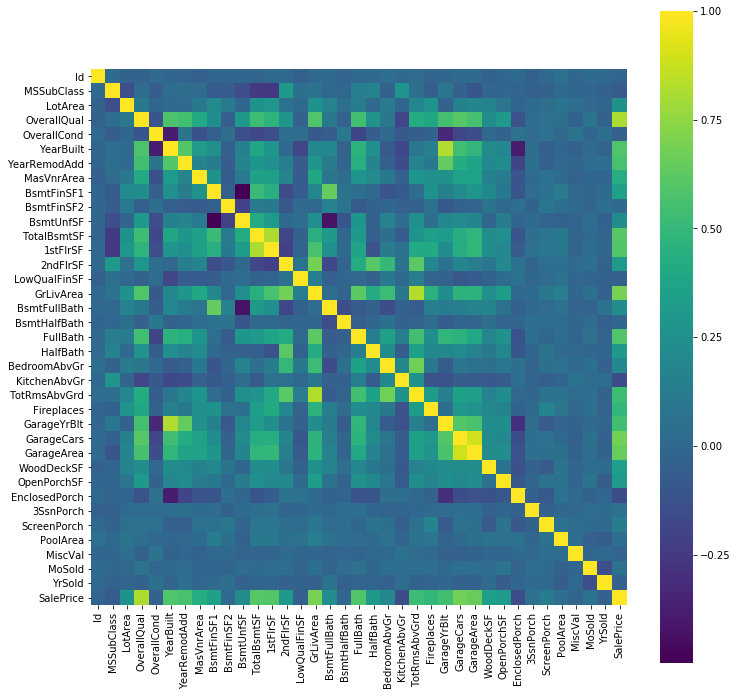

In [16]:
corr_matrix = X_train.corr()

# plt.imshow(corr_matrix, cmap='viridis')
# plt.colorbar()
# plt.show()

plt.subplots(figsize=(12, 12))
sns.heatmap(
    corr_matrix,
    cmap='viridis',
    square=True
    )

In [17]:
# high corr. threshold
hc_threshold = .7

corr_matrix_s = corr_matrix.abs().unstack().sort_values(ascending = False).drop_duplicates()
corr_matrix_s[(corr_matrix_s > hc_threshold) & (corr_matrix_s < 1)]

GarageArea   GarageCars      0.883585
GrLivArea    TotRmsAbvGrd    0.826619
YearBuilt    GarageYrBlt     0.822946
TotalBsmtSF  1stFlrSF        0.818003
OverallQual  SalePrice       0.813941
dtype: float64

In [18]:
to_drop = [
    'GarageYrBlt',
    '1stFlrSF',
    'TotRmsAbvGrd',
    'GarageArea'
] + ['SalePrice', 'Id']

In [19]:
corr_matrix['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.813941
GrLivArea        0.692783
GarageCars       0.682763
GarageArea       0.650064
TotalBsmtSF      0.606599
1stFlrSF         0.593123
YearBuilt        0.588260
FullBath         0.587581
YearRemodAdd     0.564561
GarageYrBlt      0.543056
TotRmsAbvGrd     0.525980
Fireplaces       0.487072
MasVnrArea       0.428395
BsmtFinSF1       0.360081
WoodDeckSF       0.333416
OpenPorchSF      0.319186
HalfBath         0.314034
2ndFlrSF         0.306857
LotArea          0.257131
BsmtFullBath     0.229724
BsmtUnfSF        0.224326
BedroomAbvGr     0.204937
ScreenPorch      0.120933
MoSold           0.058138
3SsnPorch        0.055992
PoolArea         0.037502
BsmtFinSF2       0.013526
BsmtHalfBath    -0.003687
MiscVal         -0.020268
Id              -0.023065
LowQualFinSF    -0.038490
YrSold          -0.038561
OverallCond     -0.038596
MSSubClass      -0.076116
KitchenAbvGr    -0.148564
EnclosedPorch   -0.152250
Name: SalePrice, dtype: float64

In [20]:
# drop() creates a copy of the data and does not affect the initial df
#X_train = train_set.drop(columns=['SalePrice', 'Id'])
X_train = train_set.drop(columns=to_drop)
X_labels = train_set['SalePrice']

In [21]:
num_attribs = list(X_train.select_dtypes('number').columns)
cat_attribs = list(X_train.select_dtypes('category').columns)

In [22]:
num_attribs

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageCars',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [23]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('inmputer', SimpleImputer(strategy='most_frequent')),
    ('1hot', OneHotEncoder(handle_unknown='ignore')),
])

In [24]:
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

X_train_prepared = full_pipeline.fit_transform(X_train)

In [25]:
forest_reg = RandomForestRegressor(n_estimators=10)
forest_reg.fit(X_train_prepared, X_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [26]:
def display_scores(scores):
    print('Scores:', scores)
    
    if scores.std() != 0:
        print('Mean:', scores.mean())
        print('Standard deviation:', scores.std())

In [27]:
forest_scores = cross_val_score(
    forest_reg,
    X_train_prepared,
    X_labels,
    scoring='neg_mean_squared_error',
    cv=10
)

forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [0.14482084 0.15339205 0.14375612 0.13319838 0.14521549 0.17370325
 0.1185286  0.17634752 0.14926954 0.14515633]
Mean: 0.14833881171196578
Standard deviation: 0.016203042564004747


In [28]:
param_grid = [
    {
        'n_estimators': range(90, 140, 10),
        'max_features': range(30, 60, 10)
    },
]


grid_search = GridSearchCV(
    forest_reg,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    return_train_score=True
)

grid_search.fit(X_train_prepared, X_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': range(30, 60, 10),

In [29]:
grid_search.best_params_

{'max_features': 50, 'n_estimators': 130}

In [30]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=50, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=130,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [31]:
# all evaluation scores
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.14170970325451385 {'max_features': 30, 'n_estimators': 90}
0.14110111767205336 {'max_features': 30, 'n_estimators': 100}
0.13986272084515566 {'max_features': 30, 'n_estimators': 110}
0.1405638764182259 {'max_features': 30, 'n_estimators': 120}
0.14048727287744633 {'max_features': 30, 'n_estimators': 130}
0.13904147512576157 {'max_features': 40, 'n_estimators': 90}
0.1387684493173966 {'max_features': 40, 'n_estimators': 100}
0.13858571476331458 {'max_features': 40, 'n_estimators': 110}
0.1390235835534675 {'max_features': 40, 'n_estimators': 120}
0.13815268823604607 {'max_features': 40, 'n_estimators': 130}
0.13712777419880492 {'max_features': 50, 'n_estimators': 90}
0.13853225440287414 {'max_features': 50, 'n_estimators': 100}
0.13740269067814087 {'max_features': 50, 'n_estimators': 110}
0.13742107320087693 {'max_features': 50, 'n_estimators': 120}
0.13647014266322052 {'max_features': 50, 'n_estimators': 130}


In [32]:
# feature_importances = grid_search.best_estimator_.feature_importances_
# print(feature_importances)

In [33]:
forest_model = grid_search.best_estimator_

X_test = test_set.drop(columns=['SalePrice'])
y_test = test_set['SalePrice'].copy()

X_test_prepared = full_pipeline.transform(X_test)
forest_model_predictions = forest_model.predict(X_test_prepared)

forest_model_mse = mean_squared_error(y_test, forest_model_predictions)
forest_model_rmse = np.sqrt(forest_model_mse)

display_scores(forest_model_rmse)

Scores: 0.13832010745936774


In [37]:
df_test = pd.read_csv(
    REP_DATA / 'test.csv'
)

y_test_prepared = full_pipeline.transform(df_test)
forest_model_predictions = forest_model.predict(y_test_prepared)

# no log
# forest_model_predictions = np.exp(forest_model_predictions)
forest_model_predictions = np.expm1(forest_model_predictions)


In [38]:
forest_model_predictions

array([124989.08054802, 150118.43289679, 179124.09976144, ...,
       154629.30427735, 121281.72236146, 230948.54757947])

In [39]:
forest_model_result = pd.concat([df_test, pd.DataFrame(forest_model_predictions, columns=['SalePrice'])], axis=1)

In [40]:
forest_model_result[['Id', 'SalePrice']].to_csv('submission.csv', index=False)

## XGBoost

In [54]:
xgb_model = xgboost.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    colsample_bylevel=1,
    colsample_bynode=1,
    colsample_bytree=1,
    gamma=0,
    importance_type='gain',
    learning_rate=0.1,
    max_delta_step=0,
    max_depth=3,
    min_child_weight=1,
    missing=None,
    n_estimators=100,
    n_jobs=1,
    nthread=None,
    objective='reg:squarederror',
    random_state=0,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    seed=None,
    silent=None,
    subsample=1,
    verbosity=1
)

xgb_model.fit(X_train_prepared, X_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [56]:
xgb_scores = cross_val_score(
    xgb_model,
    X_train_prepared,
    X_labels,
    scoring='neg_mean_squared_error',
    cv=10
)

xgb_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

c:\program files\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\program files\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\program files\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\program files\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\program files\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\program file

Scores: [0.14482084 0.15339205 0.14375612 0.13319838 0.14521549 0.17370325
 0.1185286  0.17634752 0.14926954 0.14515633]
Mean: 0.14833881171196578
Standard deviation: 0.016203042564004747


In [69]:
param_grid = [
    {
        'colsample_bytree': [.4],
        'gamma': [0],
        'learning_rate': [.07],  # np.arange(.04, .09, .01),
        'max_depth': [3],
        'min_child_weight': [1.5],  # np.arange(1, 2, .1),
        'n_estimators': range(10000, 30000, 4000),
        'reg_alpha': [.75],  # np.arange(.6, .8, .1),
        'reg_lambda': [.45],  # np.arange(.2, .6, .1),
        'subsample': [.6]  # np.arange(.4, .6, .1)
    },
]


grid_search = GridSearchCV(
    xgb_model,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    return_train_score=True
)

grid_search.fit(X_train_prepared, X_labels)

c:\program files\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\program files\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\program files\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\program files\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\program files\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\program file

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_st...
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid=[{'colsample_bytree': [0.4], 'gamma': [0],
                          'learning_rate': [0.07], 'max_depth': [3],
                          'min_child_weight': [1.5],
                          'n_estimato

In [70]:
grid_search.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0,
 'learning_rate': 0.07,
 'max_depth': 3,
 'min_child_weight': 1.5,
 'n_estimators': 10000,
 'reg_alpha': 0.75,
 'reg_lambda': 0.45,
 'subsample': 0.6}

In [71]:
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=None,
             n_estimators=10000, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0.75,
             reg_lambda=0.45, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.6, verbosity=1)

In [72]:
#xgb_model = xgboost.XGBRegressor(
#    colsample_bytree=0.4,
#    gamma=0,                 
#    learning_rate=0.07,
#    max_depth=3,
#    min_child_weight=1.5,
#    n_estimators=20000,                                                                    
#    reg_alpha=0.75,
#    reg_lambda=0.45,
#    subsample=0.6,
#    seed=4
#)

xgb_model = grid_search.best_estimator_

xgb_model.fit(
    X_train_prepared,
    X_labels
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=None,
             n_estimators=10000, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0.75,
             reg_lambda=0.45, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.6, verbosity=1)

In [73]:
X_test_prepared = full_pipeline.transform(X_test)
X_test_predictions = xgb_model.predict(X_test_prepared)

xgb_model_mse = mean_squared_error(y_test, X_test_predictions)
xgb_model_rmse = np.sqrt(xgb_model_mse)

display_scores(xgb_model_rmse)

Scores: 0.11403142776650461


In [74]:
xgb_model_predictions = xgb_model.predict(y_test_prepared)
xgb_model_predictions = np.expm1(xgb_model_predictions)

xgb_model_result = pd.concat([df_test, pd.DataFrame(xgb_model_predictions, columns=['SalePrice'])], axis=1)
xgb_model_result[['Id', 'SalePrice']].to_csv('submission.csv', index=False)